$\color{cyan}{\textbf{Assignment 3 - Fisher Faces}}$

Trabalho realizado por:

    Pedro Ferreira Nº2018285801
    Telmo Cunha Nº 2018308321

$\color{cyan}{\textbf{Imports}}$

In [53]:
from time import time
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import math
import numpy.matlib
from random import randint

In [54]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[int(y_pred[i])].rsplit(" ", 1)[-1]
    true_name = target_names[int(y_test[i])].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)

$\color{cyan}{\textbf{Function to help in the PCA and LDA calculations}}$

In [55]:
def asRowMatrix(X):
	if len(X) == 0:
		return np.array([])
	mat = np.empty((0, X[0].size), dtype=X[0].dtype)
	for row in X:
		mat = np.vstack((mat, np.asarray(row).reshape(1,-1)))
	return mat

def asColumnMatrix(X):
	if len(X) == 0:
		return np.array([])
	mat = np.empty((X[0].size, 0), dtype=X[0].dtype)
	for col in X:
		mat = np.hstack((mat, np.asarray(col).reshape(-1,1)))
	return mat

def normalize(X, low, high, dtype=None):
	X = np.asarray(X)
	minX, maxX = np.min(X), np.max(X)
	# normalize to [0...1].	
	X = X - float(minX)
	X = X / float((maxX - minX))
	# scale to [low...high].
	X = X * (high-low)
	X = X + low
	if dtype is None:
		return np.asarray(X)
	return np.asarray(X, dtype=dtype)

import numpy as np

class AbstractDistance(object):
	def __init__(self, name):
		self._name = name
		
	def __call__(self,p,q):
		raise NotImplementedError("Every AbstractDistance must implement the __call__ method.")
		
	@property
	def name(self):
		return self._name

	def __repr__(self):
		return self._name
		
class EuclideanDistance(AbstractDistance):

	def __init__(self):
		AbstractDistance.__init__(self,"EuclideanDistance")

	def __call__(self, p, q):
		p = np.asarray(p).flatten()
		q = np.asarray(q).flatten()
		return np.sqrt(np.sum(np.power((p-q),2)))

class CosineDistance(AbstractDistance):

	def __init__(self):
		AbstractDistance.__init__(self,"CosineDistance")

	def __call__(self, p, q):
		p = np.asarray(p).flatten()
		q = np.asarray(q).flatten()
		return -np.dot(p.T,q) / (np.sqrt(np.dot(p,p.T)*np.dot(q,q.T)))

In [56]:
def project(W, X, mu=None):
	if mu is None:
		return np.dot(X,W)
	return np.dot(X - mu, W)

def reconstruct(W, Y, mu=None):
	if mu is None:
		return np.dot(Y,W.T)
	return np.dot(Y, W.T) + mu

def pca(X, y, num_components=0):
	[n,d] = X.shape
	if (num_components <= 0) or (num_components>n):
		num_components = n
	mu = X.mean(axis=0)
	X = X - mu
	if n>d:
		C = np.dot(X.T,X)
		[eigenvalues,eigenvectors] = np.linalg.eigh(C)
	else:
		C = np.dot(X,X.T)
		[eigenvalues,eigenvectors] = np.linalg.eigh(C)
		eigenvectors = np.dot(X.T,eigenvectors)
		for i in range(n):
			eigenvectors[:,i] = eigenvectors[:,i]/np.linalg.norm(eigenvectors[:,i])
	# or simply perform an economy size decomposition
	# eigenvectors, eigenvalues, variance = np.linalg.svd(X.T, full_matrices=False)
	# sort eigenvectors descending by their eigenvalue
	idx = np.argsort(-eigenvalues)
	eigenvalues = eigenvalues[idx]
	eigenvectors = eigenvectors[:,idx]
	# select only num_components
	eigenvalues = eigenvalues[0:num_components].copy()
	eigenvectors = eigenvectors[:,0:num_components].copy()
	return [eigenvalues, eigenvectors, mu]
		
def lda(X, y, num_components=0):
	y = np.asarray(y)
	[n,d] = X.shape
	c = np.unique(y)
	if (num_components <= 0) or (num_components>(len(c)-1)):
		num_components = (len(c)-1)
	meanTotal = X.mean(axis=0)
	Sw = np.zeros((d, d), dtype=np.float32)
	Sb = np.zeros((d, d), dtype=np.float32)
	for i in c:
		Xi = X[np.where(y==i)[0],:]
		meanClass = Xi.mean(axis=0)
		Sw = Sw + np.dot((Xi-meanClass).T, (Xi-meanClass))
		Sb = Sb + n * np.dot((meanClass - meanTotal).T, (meanClass - meanTotal))
	eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(Sw)*Sb)
	idx = np.argsort(-eigenvalues.real)
	eigenvalues, eigenvectors = eigenvalues[idx], eigenvectors[:,idx]
	eigenvalues = np.array(eigenvalues[0:num_components].real, dtype=np.float32, copy=True)
	eigenvectors = np.array(eigenvectors[0:,0:num_components].real, dtype=np.float32, copy=True)
	return [eigenvalues, eigenvectors]

def fisherfaces(X,y,num_components=0):
	y = np.asarray(y)
	[n,d] = X.shape
	c = len(np.unique(y))
	[eigenvalues_pca, eigenvectors_pca, mu_pca] = pca(X, y, (n-c))
	[eigenvalues_lda, eigenvectors_lda] = lda(project(eigenvectors_pca, X, mu_pca), y, num_components)
	eigenvectors = np.dot(eigenvectors_pca,eigenvectors_lda)
	return [eigenvalues_lda, eigenvectors, mu_pca]

In [57]:
class BaseModel(object):
	def __init__(self, X=None, y=None, dist_metric=EuclideanDistance(), num_components=0):
		self.dist_metric = dist_metric
		self.num_components = 0
		self.projections = []
		self.W = []
		self.mu = []
		if (X is not None) and (y is not None):
			self.compute(X,y)
	
	def compute(self, X, y):
		raise NotImplementedError("Every BaseModel must implement the compute method.")
		
	def predict(self, X):
		minDist = np.finfo('float').max
		minClass = -1
		Q = project(self.W, X.reshape(1,-1), self.mu)
		for i in range(len(self.projections)):
			dist = self.dist_metric(self.projections[i], Q)
			if dist < minDist:
				minDist = dist
				minClass = self.y[i]
		return minClass
        
class FisherfacesModel ( BaseModel ):
    def __init__ ( self , X= None , y= None , dist_metric = EuclideanDistance () , num_components=0):
        super(FisherfacesModel , self ). __init__ (X=X ,y=y , dist_metric = dist_metric ,num_components = num_components)
    def compute ( self , X , y):
        [D , self .W , self . mu ] = fisherfaces ( asRowMatrix (X ) ,y , self . num_components )
        # store labels
        self .y = y
        # store projections
        for xi in X :
            self . projections . append ( project ( self .W , xi . reshape (1 , -1) , self . mu ))


$\color{cyan}{\textbf{Build the dataset}}$

In [58]:
flag = "age"
balance_dataset = True

In [59]:
separation = 10

folderPath = "Image Datasets/crop_part1"
files_paths = os.listdir(folderPath)

img = cv2.imread(os.path.join(folderPath ,files_paths[0]))
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
h, w = img_gray.shape
        
img_data = []
labels_origin = []

for filename in files_paths:
    img = cv2.imread(os.path.join(folderPath ,filename))

    x = filename.split("_")

    if flag.lower()=="age":
        labels_origin.append(math.floor((int(x[0])+1)/separation))
    else:
        index=1
        if len(x)<4:
            continue

        labels_origin.append(int(x[1]))
        
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    img_data.append(img_gray.ravel())

img_data = np.array(img_data)
labels_origin = np.array(labels_origin)

In [60]:
print("Total labels: "+str(len(labels_origin)))
print("Total images: "+str(len(img_data)))

Total labels: 9780
Total images: 9780


In [61]:
#Verify if there's a class with few examples, and eliminates it

labels = labels_origin
classes = np.unique(labels)
print("Classes:", classes)
for i in range(len(classes)):
    Classe_N = sum((labels==classes[i]).astype('int'))
    
    print("Class", i , "has" ,Classe_N, "samples.")
    if Classe_N<100:
        indexs = np.array(np.where(labels==classes[i])).ravel()
        labels = np.delete(labels, indexs)
        img_data = np.delete(img_data, indexs, 0)

classes = np.unique(labels)
print(classes)

Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Class 0 has 2787 samples.
Class 1 has 1319 samples.
Class 2 has 1425 samples.
Class 3 has 1048 samples.
Class 4 has 712 samples.
Class 5 has 978 samples.
Class 6 has 670 samples.
Class 7 has 408 samples.
Class 8 has 318 samples.
Class 9 has 108 samples.
Class 10 has 5 samples.
Class 11 has 2 samples.
[0 1 2 3 4 5 6 7 8 9]


In [62]:
#if we need to balance the dataset (same number of examples in each class)

if balance_dataset == True:
    threshold=100
    counter=np.zeros((1,len(classes)))

    labels_copy = []
    img_data_copy = []

    for i in range(len(classes)):
        classe = classes[i]
        for j in range(len(labels)):
            if classe==labels[j]:
                counter[0,i] = counter[0,i] + 1
                labels_copy.append(labels[j])
                img_data_copy.append(img_data[j,:])
            if counter[0,i]>=threshold:
                break

        print(i,"-",counter)


labels = np.array(labels_copy)
img_data = np.array(img_data_copy)

0 - [[100.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]
1 - [[100. 100.   0.   0.   0.   0.   0.   0.   0.   0.]]
2 - [[100. 100. 100.   0.   0.   0.   0.   0.   0.   0.]]
3 - [[100. 100. 100. 100.   0.   0.   0.   0.   0.   0.]]
4 - [[100. 100. 100. 100. 100.   0.   0.   0.   0.   0.]]
5 - [[100. 100. 100. 100. 100. 100.   0.   0.   0.   0.]]
6 - [[100. 100. 100. 100. 100. 100. 100.   0.   0.   0.]]
7 - [[100. 100. 100. 100. 100. 100. 100. 100.   0.   0.]]
8 - [[100. 100. 100. 100. 100. 100. 100. 100. 100.   0.]]
9 - [[100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]]


$\color{cyan}{\textbf{Verifying the data}}$

In [63]:
# introspect the images arrays to find the shapes (for plotting)
n_samples = len(labels) 

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = img_data
n_features = h*w

# the label to predict is the id of the person
y = labels
n_classes =len(np.unique(y))

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1000
n_features: 40000
n_classes: 10


$\color{cyan}{\textbf{Split the Dataset}}$

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

$\color{cyan}{\textbf{Preprocess the datasets}}$

In [65]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

mu = np.mean(X_train, axis=0)
mu1 = np.matlib.repmat(np.mean(X_train, axis=0), len(X_train), 1)
mu2 = np.matlib.repmat(np.mean(X_test, axis=0), len(X_test), 1)
X_train = X_train-mu1
X_test = X_test-mu2

In [66]:
#Get class names for plotting
target_names = []
c_class = np.unique(y_test)
genders = ["Male","Female"]

if flag.lower()=="age":
    dist = 10
    for i in range(len(np.unique(y_test))):
        target_names.append(str(dist*c_class[i])+"-"+str(dist*c_class[i]+dist-1))
else:

    for i in range(len(np.unique(y_test))):
        target_names.append(genders[i])


$\color{cyan}{\textbf{Get fisher faces components}}$

In [67]:
model = FisherfacesModel ( X_train, y_train)

$\color{cyan}{\textbf{Get data projections}}$

In [68]:
proj = np.array(model.projections)
_, _, n_components = proj.shape
proj_2 = np.reshape(proj, (len(proj),n_components))

$\color{cyan}{\textbf{Fitting the data}}$

In [69]:
print("Fitting the classifier to the training set")
t0 = time()

clf = SVC(kernel="linear", class_weight="balanced", C=10)

clf = clf.fit(proj_2, model.y)
print("done in %0.3fs" % (time() - t0))


Fitting the classifier to the training set
done in 0.004s


$\color{cyan}{\textbf{Getting performance measurements on the training data}}$

Predicting people's names on the training set
done in 0.003s
              precision    recall  f1-score   support

         0-9       1.00      1.00      1.00        71
       10-19       1.00      1.00      1.00        83
       20-29       1.00      1.00      1.00        69
       30-39       1.00      1.00      1.00        73
       40-49       1.00      1.00      1.00        82
       50-59       1.00      1.00      1.00        71
       60-69       1.00      1.00      1.00        72
       70-79       1.00      1.00      1.00        84
       80-89       1.00      1.00      1.00        73
       90-99       1.00      1.00      1.00        72

    accuracy                           1.00       750
   macro avg       1.00      1.00      1.00       750
weighted avg       1.00      1.00      1.00       750

Mean Precision: 1.0
Mean F1-Score: 1.0
Mean Recall: 1.0


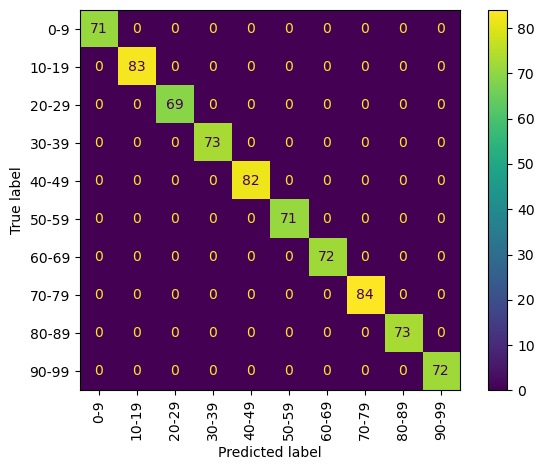

In [70]:
print("Predicting people's names on the training set")
t0 = time()
y_pred = clf.predict(proj_2)
print("done in %0.3fs" % (time() - t0))

print(classification_report(model.y, y_pred, target_names=target_names))
print("Mean Precision: "+str(precision_score(model.y, y_pred, average='macro')))
print("Mean F1-Score: "+str(f1_score(model.y, y_pred, average='macro')))
print("Mean Recall: "+str(recall_score(model.y, y_pred, average='macro')))


ConfusionMatrixDisplay.from_estimator(
    clf, proj_2, model.y, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

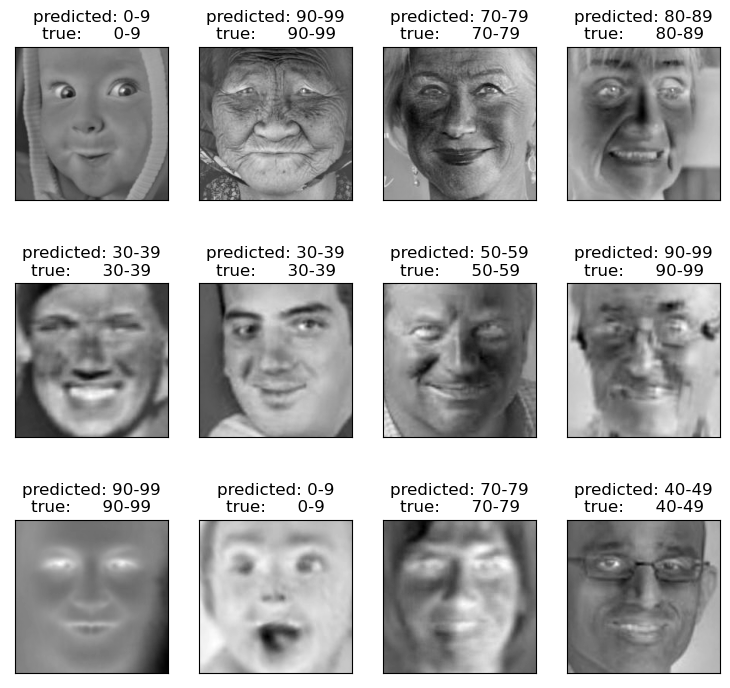

In [71]:
prediction_titles = [title(y_pred, y_train, target_names, i) for i in range(y_pred.shape[0])]
plot_gallery(X_train, prediction_titles, h, w)

$\color{cyan}{\textbf{Getting performance measurements on the test data}}$

Predicting people's names on the test set
done in 0.001s
              precision    recall  f1-score   support

         0-9       1.00      0.83      0.91        29
       10-19       0.42      0.65      0.51        17
       20-29       0.40      0.26      0.31        31
       30-39       0.17      0.19      0.18        27
       40-49       0.13      0.17      0.15        18
       50-59       0.27      0.28      0.27        29
       60-69       0.25      0.18      0.21        28
       70-79       0.08      0.19      0.11        16
       80-89       0.38      0.19      0.25        27
       90-99       0.27      0.25      0.26        28

    accuracy                           0.32       250
   macro avg       0.34      0.32      0.32       250
weighted avg       0.36      0.32      0.33       250

Mean Precision: 0.3373361396224964
Mean F1-Score: 0.3153796608878844
Mean Recall: 0.31616800811289786


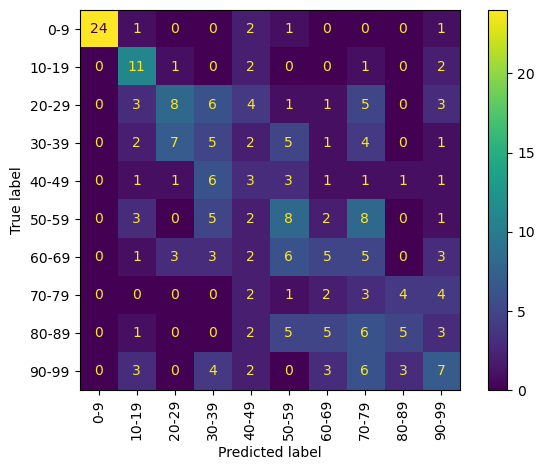

In [72]:
X_test_fisher = []

for xi in X_test :
    X_test_fisher.append(project ( model.W , xi. reshape (1 , -1) , model. mu ))

X_test_fisher = np.array(X_test_fisher)
size,_,_ = X_test_fisher.shape
X_test_fisher_2 = np.reshape(X_test_fisher, (size,n_components))

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_fisher_2)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print("Mean Precision: "+str(precision_score(y_test, y_pred, average='macro')))
print("Mean F1-Score: "+str(f1_score(y_test, y_pred, average='macro')))
print("Mean Recall: "+str(recall_score(y_test, y_pred, average='macro')))
ConfusionMatrixDisplay.from_estimator(clf, X_test_fisher_2, y_test, display_labels=target_names, xticks_rotation="vertical")

plt.tight_layout()
plt.show()

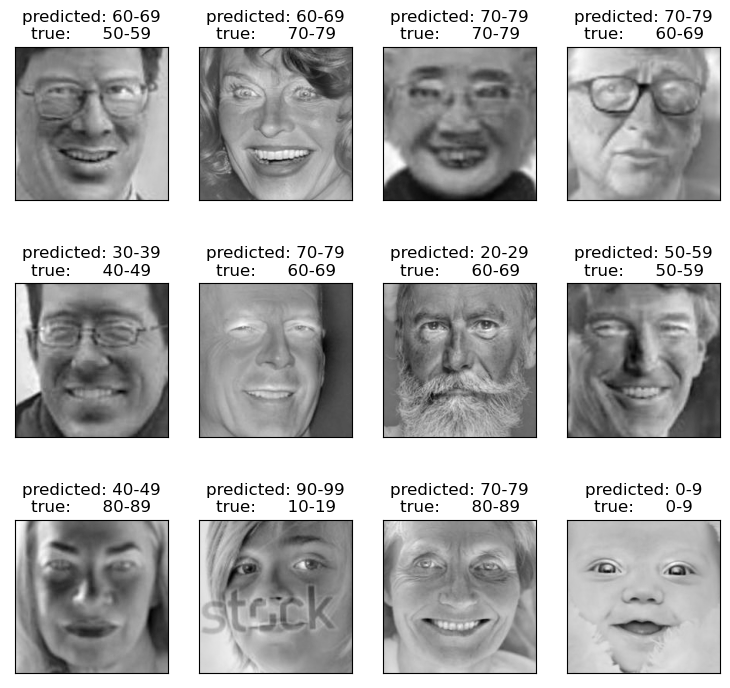

In [73]:
prediction_titles = [title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)

$\color{cyan}{\textbf{Visualize the Fisher Faces}}$

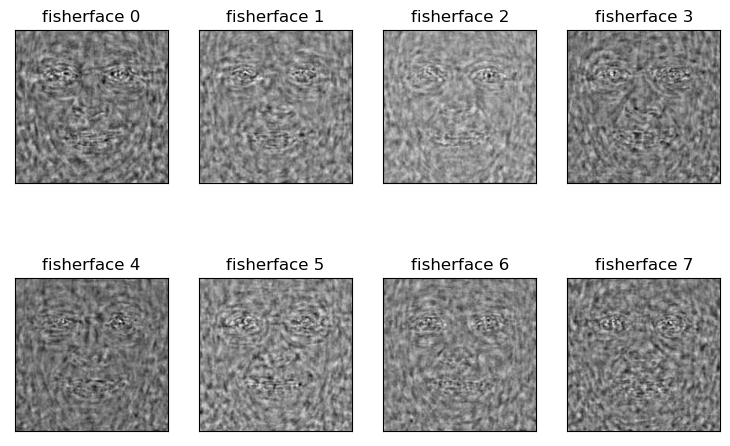

In [74]:
W = np.transpose(model.W)

eigenface_titles = ["fisherface %d" % i for i in range(W.shape[0])]

if flag.lower()=="age":
    plot_gallery(W, eigenface_titles, h, w, n_row=2, n_col=4)
else:
    plot_gallery(W, eigenface_titles, h, w, n_row=1, n_col=1)

plt.show()

$\color{cyan}{\textbf{Trying to reconstruct the original data}}$

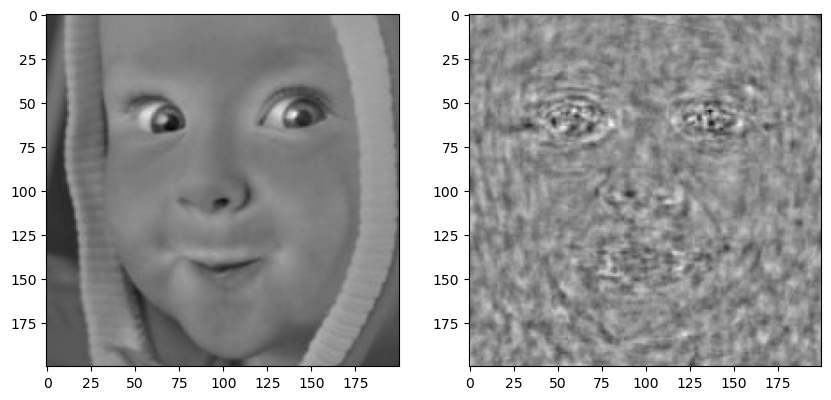

In [75]:
index = 0

mu = model.mu
components_ = model.W


img_O = np.reshape(X_train[index,:], (200,200)) 

aux = np.reshape(proj_2[index,:], (1,len(proj_2[index,:])))
img = np.matmul(aux,  np.transpose(components_) ) + mu
img = np.reshape(img, (200,200)) 

fig = plt.figure(figsize=(10, 7))
rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(img_O, cmap='gray')
fig.add_subplot(rows, columns, 2)
plt.imshow(img, cmap='gray')

plt.show()

$\color{cyan}{\textbf{Ploting relation between first and second components}}$

In [76]:
X_aux = proj_2
y_aux = y_train

In [77]:

X_aux = []
counter = np.zeros(len(c_class))

for i in range(len(c_class)):
    for j in range(len(y_train)):
        if y_train[j]==c_class[i]:
            X_aux.append(proj_2[j])
            counter[i] = counter[i] + 1
    
X_aux = np.array(X_aux)

0
70
70
153
153
222
222
295
295
377
377
448
448
520
520
604
604
677
677
749


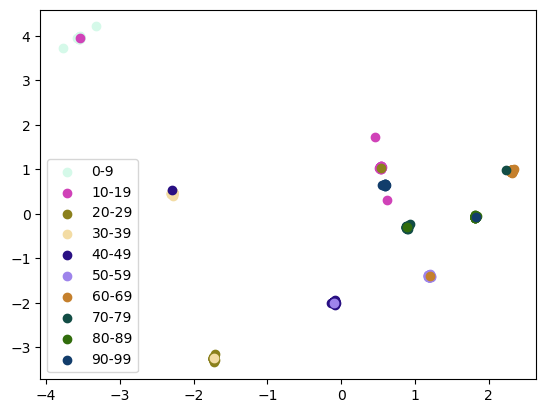

In [78]:

cols = ['#{:06x}'.format(randint(0, 0xffffff)) for i in range(len(y_aux))]

default_colors =["red","blue"]
pltCol = [cols[int(k)] for k in range(len(c_class))]

plt.figure()

for i in range(len(c_class)):

    sup_index = int(np.sum(counter[:i+1])-1)
    inf_index = int(np.sum(counter[:i])-1)

    if sup_index<0: sup_index=0
    if inf_index<0: inf_index=0

    print("=================")
    print(inf_index)
    print(sup_index)

    if flag.lower()=="age":
        plt.scatter(X_aux[inf_index:sup_index, 0], X_aux[inf_index:sup_index, 1], color=pltCol[i], label = target_names[i])
    else:
        if i==0:
            plt.plot(X_aux[inf_index:sup_index,0], color=default_colors[i], linewidth=2)
        else:
            plt.plot(X_aux[inf_index:sup_index,0], color=default_colors[i], linewidth=1)
plt.legend()
plt.show()